# Imports

In [2]:
import json
from unidecode import unidecode
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from datetime import datetime
import plotly.express as px
import os
import matplotlib.pyplot as plt
import tempfile
from sklearn.preprocessing import FunctionTransformer
from sklego.preprocessing import RepeatingBasisFunction

import pprint
from typing import Dict, Text
from datetime import date

%matplotlib inline

## SEED

In [5]:
SEED = 42
tf.random.set_seed(SEED)

# Data

## Cleaner Functions

In [6]:
def name_2_month(data):
    d = {'enero': '1', 'febrero': '2', 'marzo': '3', 'abril': '4', 'mayo': '5', 'junio': '6', 'julio': '7', 'agosto': '8', 'septiembre': '9', 'octubre': '10', 'noviembre': '11', 'diciembre': '12'}
    data = data.map(d)
    return data

In [7]:
def fix_date(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Serializa la fecha del dataframe

    Parameters
    ----------
    df : pd.DataFrame
    
    Returns
    -------
    pd.DataFrame

    '''
    date = df['FECHA'].str.split(' ', expand=True)
    month_day = date[1]
    month = date[3]
    month_number = name_2_month(month)
    year = date[5]
    df['FECHA'] = pd.to_datetime(year + '-' + month_number + '-' + month_day)

    return df

## Data Loaders

In [8]:
with open('standard_names.json','r') as f:
    standards_names = json.load(f)

standards_names = {key: unidecode(value) for key, value in standards_names.items()}

In [9]:
with open('products_description.json','r') as f:
    products_description = json.load(f)

products_description = {unidecode(key): unidecode(value) for key, value in products_description.items()}

In [10]:
df = pd.read_excel('Vtas Bar Septiembre 2022.xlsx')
df = fix_date(df)

## Data Viz

In [11]:
df.head()

,TIPO_DOC,NRO_DOC,FECHA,HORA,TOT_DOC,FOR_PAGO,NOMPROD,CANTIDAD,PRECIO,TOTAL,nomcc
0,BOLETA,120719,2022-09-02,23:01:10,59700,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
1,BOLETA,120719,2022-09-02,23:01:10,59700,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
2,BOLETA,120714,2022-09-02,00:00:03,6900,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
3,BOLETA,120710,2022-09-02,21:56:55,81700,Tarjeta Crdto.,PISCOLON,1,5300,5300,BAR SOCIOS
4,BOLETA,120690,2022-09-02,18:56:56,42500,Tarjeta Crdto.,ABSOLUT SABORES,1,3900,3900,BAR SOCIOS


In [74]:
df['HORA']

0       23:01:10
1       23:01:10
2       00:00:03
3       21:56:55
4       18:56:56
          ...   
4173    21:44:19
4174    19:46:35
4175    20:37:26
4176    12:44:35
4177    22:33:27
Name: HORA, Length: 4178, dtype: object

In [75]:
pd.to_datetime(df['HORA'].astype(str), format='%H:%M:%S').dt.hour

0       23
1       23
2        0
3       21
4       18
        ..
4173    21
4174    19
4175    20
4176    12
4177    22
Name: HORA, Length: 4178, dtype: int64

## Data Preprocessing

In [52]:
def preprocess_day(df, column, period):
  """Funcion que toma la columna dia y crea dos features utilizando esa variable"""
  df[f'sin_{column}'] = np.sin(2 * np.pi * df[column] / period)
  df[f'cos_{column}'] = np.cos(2 * np.pi * df[column] / period)
  return df

In [12]:
desc_df = pd.DataFrame.from_dict(products_description, orient='index', columns=['description'])
desc_df.reset_index(inplace=True)
desc_df.rename(columns={'index': 'product'}, inplace=True)


In [13]:
desc_df.head()

,product,description
0,Austral Calafate,
1,Agua Mineral Sin Gas,
2,Tom Collins,"Gin kantal, jugo de limon, jarabe de goma, soda"
3,Jugo Nectar Naranja,
4,Campari,


In [104]:
rec_df = pd.DataFrame()
rec_df['user_id'] = df['NRO_DOC']
rec_df['product'] = df['NOMPROD']
rec_df['quantity'] = df['CANTIDAD']
rec_df['date'] = pd.to_datetime(df['FECHA'].astype(str))
rec_df['weekday'] = rec_df['date'].dt.dayofweek
rec_df['hour'] = pd.to_datetime(df['HORA'].astype(str), format='%H:%M:%S').dt.hour

rec_df['product'] = rec_df['product'].map(standards_names)
rec_df['description'] = rec_df['product'].map(products_description)

rec_df = rec_df.groupby(by=['user_id','product','weekday','hour', 'description'], as_index=False)['quantity'].sum()

In [106]:
rec_df = preprocess_day(rec_df, 'weekday', 7)
rec_df = preprocess_day(rec_df, 'hour', 24)

In [107]:
rec_df.head()

,user_id,product,weekday,hour,description,quantity,sin_weekday,cos_weekday,sin_hour,cos_hour
0,7359,Agua Mineral Sin Gas,5,13,,1,-0.974928,-0.222521,-2.588190e-01,-0.965926
1,7359,Arrollados Primavera / Jamon Queso,5,13,rollitos acompanados de salsa de soya,1,-0.974928,-0.222521,-2.588190e-01,-0.965926
2,7359,Canada Dry,5,13,,2,-0.974928,-0.222521,-2.588190e-01,-0.965926
3,7359,Mojito,5,13,"Ron, jugo de limon, jarabe de goma, menta fres...",1,-0.974928,-0.222521,-2.588190e-01,-0.965926
4,117186,Michelada,3,12,,1,0.433884,-0.900969,1.224647e-16,-1.000000


# Model

In [131]:
rec_df['user_id'] = rec_df['user_id'].astype('str')
rec_df['product'] = rec_df['product'].astype('str')
rec_df['quantity'] = rec_df['quantity'].astype('int')
rec_df['sin_weekday'] = rec_df['sin_weekday'].astype('float')
rec_df['cos_weekday'] = rec_df['cos_weekday'].astype('float')
rec_df['sin_hour'] = rec_df['sin_hour'].astype('float')
rec_df['cos_hour'] = rec_df['cos_hour'].astype('float')
rec_df['description'] = rec_df['description'].astype('str')

desc_df['product'] = desc_df['product'].astype('str')

In [132]:
rating_dataset = tf.data.Dataset.from_tensor_slices((
        tf.cast(rec_df['user_id'].values.reshape(-1,1), tf.string),
        tf.cast(rec_df['product'].values.reshape(-1,1), tf.string),
        tf.cast(rec_df['quantity'].values.reshape(-1,1), tf.float32),
        tf.cast(rec_df['sin_weekday'].values.reshape(-1,1), tf.float32),
        tf.cast(rec_df['cos_weekday'].values.reshape(-1,1), tf.float32),
        tf.cast(rec_df['sin_hour'].values.reshape(-1,1), tf.float32),
        tf.cast(rec_df['cos_hour'].values.reshape(-1,1), tf.float32),
        tf.cast(rec_df['description'].values.reshape(-1,1), tf.string)
))

products_dataset = tf.data.Dataset.from_tensor_slices((
        tf.cast(desc_df['product'].values.reshape(-1,1), tf.string)
))

In [133]:
@tf.function
def rename_ratings(x0,x1,x2,x3,x4,x5,x6,x7):
    y = {}
    y["user_id"] = x0
    y['product'] = x1
    y['quantity'] = x2
    y['sin_weekday'] = x3
    y['cos_weekday'] = x4
    y['sin_hour'] = x5
    y['cos_hour'] = x6
    y['description'] = x7
    return y

@tf.function
def rename_products(x0):
    y = {}
    y['product'] = x0
    
    return y

In [134]:
rating_dataset = rating_dataset.map(rename_ratings)
products_dataset = products_dataset.map(rename_products)

In [135]:
# Select the basic features.
rating_dataset = rating_dataset.map(lambda x: {
    "product": x["product"],
    "user_id": x["user_id"],
    "quantity": x["quantity"],
    "sin_weekday": x["sin_weekday"],
    "cos_weekday": x["cos_weekday"],
    "sin_hour": x["sin_hour"],
    "cos_hour": x["cos_hour"],
    "description" : x["description"]
})

products_dataset = products_dataset.map(lambda x: x["product"])

In [136]:
DATASET_SIZE = rating_dataset.cardinality().numpy()

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

shuffled = rating_dataset.shuffle(DATASET_SIZE, seed=SEED, reshuffle_each_iteration=False)

train_dataset = shuffled.take(train_size)
test_dataset = shuffled.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [137]:
unique_products = np.unique(np.concatenate(list(products_dataset)))
unique_user_ids = np.unique(np.concatenate(list(rating_dataset.map(lambda x: x['user_id']))))

In [138]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        #set up user embedding
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None
            ),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
        ])

        self.description_embedding = tf.keras.Sequential([
            tf.keras.layers.TextVectorization(max_tokens=max_tokens),
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            # We average the embedding of individual words to get one embedding vector
            # per description.
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.normalized_quantity = tf.keras.layers.Normalization(
            axis=None
        )
        self.normalized_sin_day = tf.keras.layers.Normalization(
            axis=None
        )
        self.normalized_cos_day = tf.keras.layers.Normalization(
            axis=None
        )
        self.normalized_sin_hour = tf.keras.layers.Normalization(
            axis=None
        )
        self.normalized_cos_hour = tf.keras.layers.Normalization(
            axis=None
        )
    
    def call(self, inputs):
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.description_embedding(inputs["description"]),
            tf.reshape(self.normalized_quantity(inputs["quantity"]), (-1, 1)),
            tf.reshape(self.normalized_sin_day(inputs["sin_weekday"]), (-1, 1)),
            tf.reshape(self.normalized_cos_day(inputs["cos_weekday"]), (-1, 1)),
            tf.reshape(self.normalized_sin_hour(inputs["sin_hour"]), (-1, 1)),
            tf.reshape(self.normalized_cos_hour(inputs["cos_hour"]), (-1, 1)),

        ], axis=1)

In [139]:
class ProductModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        #set up product embedding
        self.product_name_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_products, mask_token=None
            ),
            tf.keras.layers.Embedding(len(unique_products) + 1, 32)
        ])

        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens)


        self.title_embedding = tf.keras.Sequential([
            tf.keras.layers.TextVectorization(max_tokens=max_tokens),
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            # We average the embedding of individual words to get one embedding vector
            # per title.
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(products_dataset)
    
    def call(self, inputs):
        return tf.concat([
        self.product_name_embedding(inputs["product"]),
        self.title_embedding(inputs["product"]),
    ], axis=1)

In [140]:
class RecomenderModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()

        #set up user and product representation
        self.query_model = tf.keras.Sequential([
            UserModel(),
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            ProductModel(),
            tf.keras.layers.Dense(32)
        ])

        #set up retrieval task
        self.task = tfrs.tasks.Retrieval(
                        metrics = tfrs.metrics.FactorizedTopK(
                            candidates=products_dataset.map(self.candidate_model)
                            )
                        )
    
    def compute_loss(self, features, training=False) -> tf.Tensor:
        #Define how the loss is computed

        query_embeddings = self.query_model({
            "product": features["product"],
            "description": features["description"],
            "user_id": features["user_id"],
            "quantity": features["quantity"],
            "sin_weekday": features["sin_weekday"],
            "cos_weekday": features["cos_weekday"],
            "sin_hour": features["sin_hour"],
            "cos_hour": features["cos_hour"]
        })

        candidate_embeddings = self.candidate_model(features["product"])

        return self.task(query_embeddings,candidate_embeddings)

In [141]:
cache_train_dataset= train_dataset.cache()
cache_val_dataset = val_dataset.cache()
cache_test_dataset = test_dataset.cache()

In [142]:
# Tensorboard 
time_now = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "logs/scalars/" + time_now


checkpoint_path = f"model_{time_now}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=1, save_best_only=True)
]

In [143]:
# Create a retrieval model.
learning_rate = 0.001

model = RecomenderModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

TypeError: Exception encountered when calling layer "product_model_4" "                 f"(type ProductModel).

in user code:

    File "/tmp/ipykernel_683902/2087406554.py", line 33, in call  *
        self.title_embedding(inputs["product"]),

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'product'


Call arguments received by layer "product_model_4" "                 f"(type ProductModel):
  • inputs=tf.Tensor(shape=(1,), dtype=string)

In [96]:
# Train
history = model.fit(train_dataset, epochs=30, verbose=1, callbacks=my_callbacks, validation_data=val_dataset)

Epoch 1/30


KeyError: in user code:

    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/tensorflow_recommenders/models/base.py", line 68, in train_step
        loss = self.compute_loss(inputs, training=True)
    File "/tmp/ipykernel_683902/2861562346.py", line 38, in compute_loss
        "description": features["description"]

    KeyError: 'description'


In [299]:
products_dataset

<MapDataset element_spec=TensorSpec(shape=(1,), dtype=tf.string, name=None)>

In [300]:
test_dataset

<TakeDataset element_spec={'product': TensorSpec(shape=(1,), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(1,), dtype=tf.string, name=None)}>

In [302]:
# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(products_dataset.map(lambda product: (product, model.product_model(product))))

In [276]:
user = "42"

# Get some recommendations.
_, titles = index(np.array([user]))
print(f"Top 3 recommendations for user {user}: {titles[0, :3]}")

Top 3 recommendations for user 42: [b'Gin Kantal' b'Ballantines' b'Tabla Americana']


In [297]:
preds_metrics = model.evaluate(cache_test_dataset, return_dict=True)

269/269 [==============================] - 21s 80ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0483 - factorized_top_k/top_10_categorical_accuracy: 0.0967 - factorized_top_k/top_50_categorical_accuracy: 0.5799 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 0.0000e+00 - regularization_loss: 0.0000e+00 - total_loss: 0.0000e+00


In [314]:
date = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"trained_model_{date}"
path = os.path.join(os.getcwd(),model_name)

In [323]:
# Save the model
tf.saved_model.save(index, path+'_acurate')

INFO:tensorflow:Assets written to: /home/felipe/Desktop/memoria/trained_model_20221201-175907_acurate/assets


INFO:tensorflow:Assets written to: /home/felipe/Desktop/memoria/trained_model_20221201-175907_acurate/assets


In [321]:
#Save wit Scann
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index_from_dataset(products_dataset.map(
    lambda product: (product, model.product_model(product))))


  # Save the index.
tf.saved_model.save(
    scann_index,
    path+'_scann',
    options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

ImportError: The scann library is not present. Please install it using `pip install scann` to use the ScaNN layer.

In [ ]:
#Load Model

with tempfile.TemporaryDirectory() as tmp: 
  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
scores, titles = loaded(["42"])

print(f"Recommendations: {titles[0][:3]}")

In [291]:
for sample in test_dataset:
    real = sample['product'].numpy()[0]
    predicted = model.predict(sample)
    print(f"Real: {real} - Predicted: {predicted}")

NotImplementedError: in user code:

    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/felipe/miniconda3/envs/recomenders/lib/python3.10/site-packages/keras/engine/training.py", line 588, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer 'recomender_model_11' (type RecomenderModel).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer 'recomender_model_11' (type RecomenderModel):
      • inputs={'product': 'tf.Tensor(shape=(None,), dtype=string)', 'user_id': 'tf.Tensor(shape=(None,), dtype=string)'}
      • training=False
      • mask=None


In [266]:
accuracy = history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 1.00.


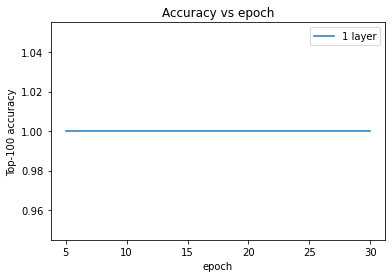

In [269]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

In [259]:
losses = pd.DataFrame()
losses['val_loss'] = history.history['factorized_top_k/top_1_categorical_accuracy']
losses['loss'] = history.history['loss']

In [260]:
fig = px.line(losses[['loss','val_loss']], title='Mean Squared Error')
fig.update_xaxes(title_text='Epoch')
fig.update_yaxes(title_text='MSE')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,)

fig.show()